## PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow

In [1]:
what_we_are_covering = {1:"data (prepare and load)",
                        2:"build model",
                        3:"fitting the model to data (training)",
                        4:"making predictions and evaluating a model (inference)",
                        5:"saving and loading a model",
                        6:"putting it all together"}

what_we_are_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks.
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

tensor([0.2525, 0.0190])

#### Create Device Agnostic Code

This means if we've got access to a GPU. our code will use it.
If no GPU is available, the code will default to using CPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 1. Data (preparing and loading)

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X+bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### Splitting data into training and test sets

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# Put data on the system device (Device Agnostic code for data)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

#### Visualize our data

In [ ]:
def plot_predictions(train_data=torch.tensor(X_train).cpu().numpy(),
                     train_labels=torch.tensor(y_train).cpu().numpy(),
                     test_data=torch.tensor(X_test).cpu().numpy(),
                     test_labels=torch.tensor(y_test).cpu().numpy(),
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=10, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=10, label="Testing data")

    # For Predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show legend
    plt.legend(prop={'size': 14})


<ipython-input-12-7f034d3f4f6e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  def plot_predictions(train_data=torch.tensor(X_train).cpu().numpy(),
<ipython-input-12-7f034d3f4f6e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(y_train).cpu().numpy(),
<ipython-input-12-7f034d3f4f6e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data=torch.tensor(X_test).cpu().numpy(),
<ipython-input-12-7f034d3f4f6e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

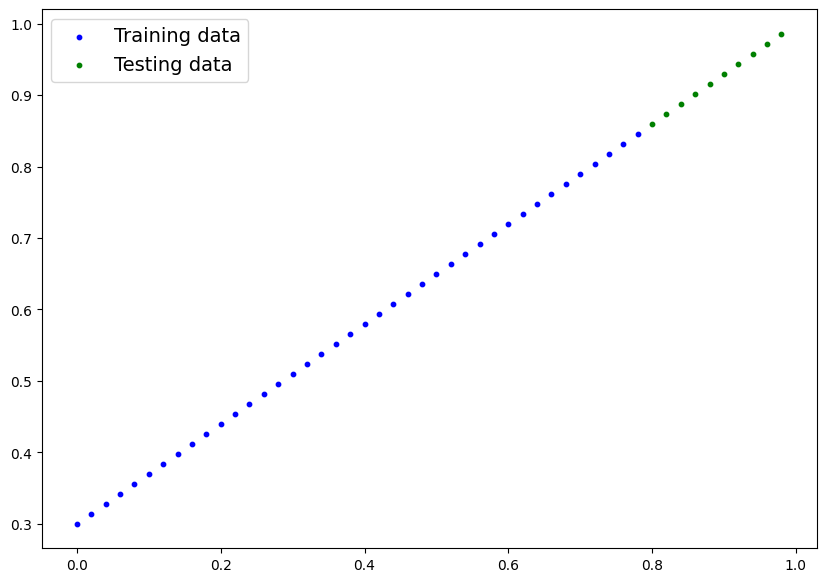

In [ ]:
plot_predictions()

### 2. Build Model

#### PyTorch model building essentials
https://pytorch.org/tutorials/beginner/ptcheat.html

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn. Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - base class for all neural network modules. If we subclass it, we should override forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require us to override forward(). This method defines what happens in the forward computation/propagation. When we call the model directly, the internal __call__ function is used. This function manages all registered hooks and calls forward afterwards. That's also the reason we should call the model directly, because otherwise our hooks might not work etc.

In [ ]:
# # Create Linear Regression model class
# from torch import nn
# class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.module. Base class for all neural networks.
#     def __init__(self):
#         super().__init__()
#         self.weights = nn.Parameter(torch.randn(1, # start with random weights
#                                                 requires_grad=True, # update weights to ideal weights for the model
#                                                 dtype=torch.float)) # PyTorch default datatype
#         self.bias = nn.Parameter(torch.randn(1,
#                                             requires_grad=True,
#                                             dtype=torch.float))

#         # Forward method to define the computation in the model
#     def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input/training data.
#         return self.weights * x + self.bias # Linear regression formula

#### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside it.

So, we can check our model parameters or what's inside our model using`.parameters()`

In [ ]:
# # Create a random seed - to get reproducible results
# torch.manual_seed(42)

# # Create an instance of the model (this is a subclass of nn.module)
# model_0 = LinearRegressionModel()

# print(list(model_0.parameters()))

# List named parameters
# print(model_0.state_dict()) # This is going to give us our dictionary of the parameters of our model

In [ ]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters/ also called: linear transformation, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_0 = LinearRegressionModelV2()
model_0

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# List named parameters
model_0.state_dict() # This is going to give us our dictionary of the parameters of our model

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [ ]:
# Check the model current device
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the system device (Device Agnostic code for model)
model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

#### Making Prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# We can also do similar with torch.no_grad() but torch.inference_mode() is preferred and faster.
# https://twitter.com/PyTorch/status/1437838231505096708?lang=en
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]], device='cuda:0')

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]], device='cuda:0')

<ipython-input-22-38d4ae76050c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(y_preds).cpu().numpy())


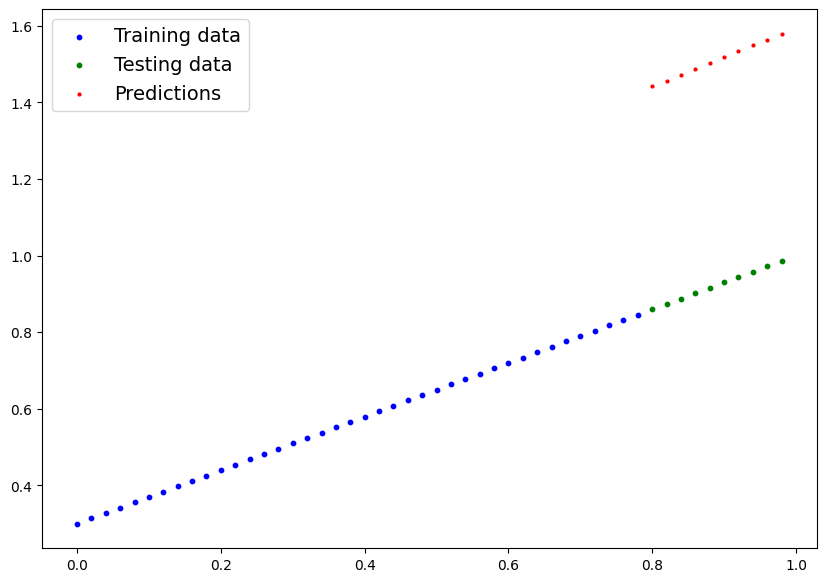

In [ ]:
plot_predictions(predictions=torch.tensor(y_preds).cpu().numpy())

### 3. Train model (fitting the model to data)

The whole idea of training a model is to move from poor representation of the data to a beter representation of the data.

One way to meausre how poor or how wrong out model predictions are is to use
a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we are going to refer to it as a loss function.

Things we need to train:

* **Loss Function:** A function to measure how wrong our model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.
    * Inside the optimizer we'll often have to set the two parameters:
        * `params` - the model parameters we'd like to optimize, for example params=model_0.parameters()
        * `lr`(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically in PyTorch, we need:

* A training loop
* A testing loop

In [ ]:
 # Our model's parameters (a parameter is a value that the model sets itself)
 model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.015) # learning rate

#### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (**Forward Propoagation**) - to make predictions on data
 (this involves data moving through our model's forward() functions)
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (**Backward Propagation**) - move backwards throught the network to calculate/compute the
  gradients of each of the paramenetrs of our model (requires_grad=True) with respect to the loss
5. Optimizer step (**Gradient Descent**) - use thie optimizer to adjust our model's parameters with respect to the gradients calculates by `loss.backward()` to try and improve the loss

In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data... (this is a hyperparameters)
epochs = 100

# Put data on the system device (Device Agnostic code for data)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Track different values
epoch_count = []
train_loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f"Loss: {loss}")

    # 3. Optimizer zero grad ( Check comment at step 5 below to understand it)
    '''
    Before performing backpropagation, you need to clear the gradients of all the parameters in the model.
    Gradients in PyTorch accumulate by default (i.e., they are added to existing gradients during each pass).
    If you don't clear the gradients, they will sum up across iterations, which will lead to incorrect updates.
    '''
    optimizer.zero_grad()

    # 4. Perform Backpropagation on the loss with respect to the parameters of the model
    '''
    This computes the gradients of the loss function with respect to all parameters in the model that have requires_grad=True.
    PyTorch uses autograd to automatically calculate these gradients based on the computational graph formed during the forward
    pass.
    '''
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    '''
    What it does: This step updates the model's parameters using the gradients computed during loss.backward() and
    the optimization algorithm (e.g., SGD, Adam, etc.) you defined. Here, we defined SGD.

    Why it's necessary: Once the gradients are computed, they need to be applied to the model's parameters to adjust them
    in the direction that reduces the loss. The optimizer handles this process.
    '''
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop.

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
    with torch.inference_mode(): # turns off gradient tracking and a couple more things behind the scenes
    # with torch.no_grad(): # In older PyTorch code, it was used to find inference.

        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    print("Let's see what's happening here...")
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(model_0.state_dict())

Let's see what's happening here...
Epoch: 0 | Loss: 0.010365366004407406 | Test loss: 0.013549727387726307
OrderedDict([('linear_layer.weight', tensor([[0.6867]], device='cuda:0')), ('linear_layer.bias', tensor([0.2983], device='cuda:0'))])
Let's see what's happening here...
Epoch: 1 | Loss: 0.006916131358593702 | Test loss: 0.006656759884208441
OrderedDict([('linear_layer.weight', tensor([[0.6926]], device='cuda:0')), ('linear_layer.bias', tensor([0.3133], device='cuda:0'))])
Let's see what's happening here...
Epoch: 2 | Loss: 0.010365366004407406 | Test loss: 0.013549727387726307
OrderedDict([('linear_layer.weight', tensor([[0.6867]], device='cuda:0')), ('linear_layer.bias', tensor([0.2983], device='cuda:0'))])
Let's see what's happening here...
Epoch: 3 | Loss: 0.006916131358593702 | Test loss: 0.006656759884208441
OrderedDict([('linear_layer.weight', tensor([[0.6926]], device='cuda:0')), ('linear_layer.bias', tensor([0.3133], device='cuda:0'))])
Let's see what's happening here...
E

To avoid the error: `can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.`, use .cpu() below

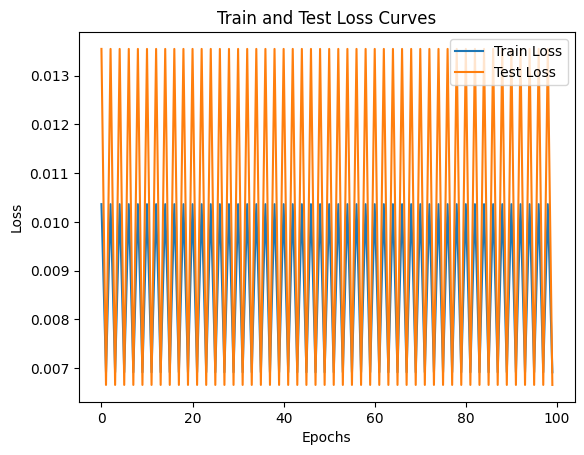

In [ ]:
# Since matplotlib works on numpy data ony, we need to convert PyTorch data to Numpy
plt.plot(epoch_count, torch.tensor(train_loss_values).cpu().numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), label="Test Loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6926]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3133], device='cuda:0'))])

In [ ]:
# Original weight and bias we defined for the linear equation
weight, bias

(0.7, 0.3)

<ipython-input-31-38d4ae76050c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(y_preds).cpu().numpy())


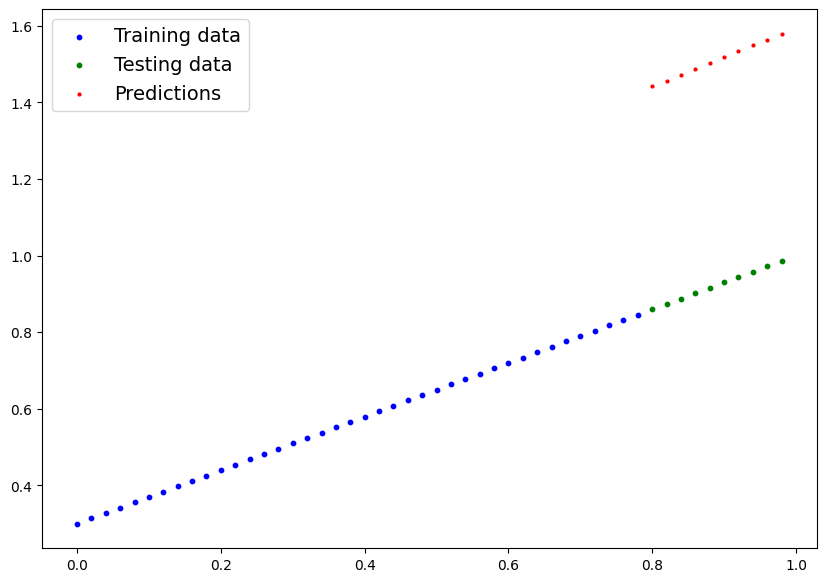

In [ ]:
plot_predictions(predictions=torch.tensor(y_preds).cpu().numpy())

To avoid the error: `can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.`, use .cpu() below

<ipython-input-32-3afbb6bfe29b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(test_pred).cpu().numpy()) # It's so much better than above. Almost optimal.


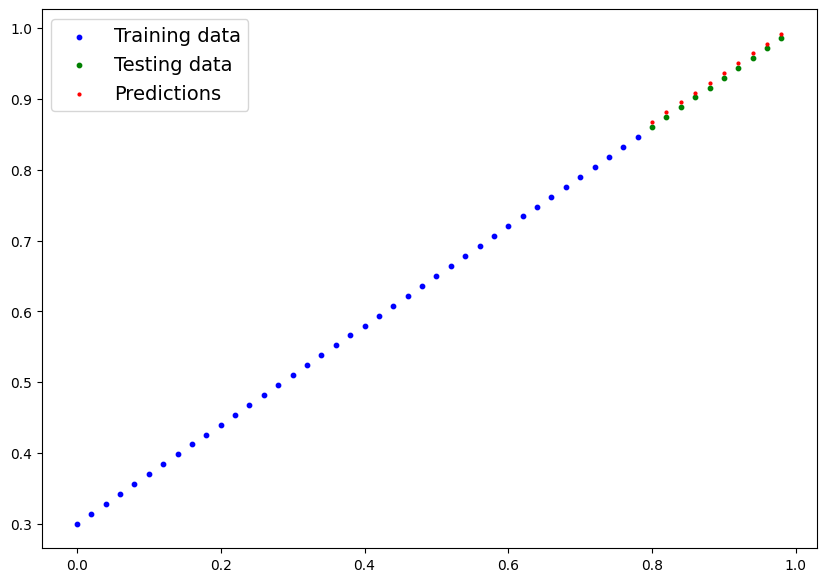

In [ ]:
plot_predictions(predictions=torch.tensor(test_pred).cpu().numpy()) # It's so much better than above. Almost optimal.

### Saving and Loading the model

https://pytorch.org/tutorials/beginner/saving_loading_models.html

There are three main methods we should know for saing and loading models in PyTorcg.

1. `torch.save()` - allows us to save a PyTorch object in Python's pickle format.

2. `torch.load()` - allows us to load a saved PyTorch object.

3. `torch.nn.Module.load_state_dict()` - this allows us to load a model's saved state dictionary.

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1744 Jan 23 03:22 01_pytorch_workflow_model_0.pth


In [ ]:
# To load a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModelV2()
print(loaded_model_0.state_dict()) # Randomly initialized


# Load the saved state_dict of model_0 (this will update the new instance with updated paraeters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_0.state_dict()) # Exact same value as model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])
OrderedDict([('linear_layer.weight', tensor([[0.6926]])), ('linear_layer.bias', tensor([0.3133]))])


<ipython-input-35-584d10130de0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [ ]:
# Current device of loaded model
next(loaded_model_0.parameters()).device

# Set the model to use the system device (Device Agnostic code for model)
loaded_model_0.to(device)
next(loaded_model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval() # In eval() mode, it gets faster


with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8673],
        [0.8812],
        [0.8950],
        [0.9089],
        [0.9227],
        [0.9366],
        [0.9504],
        [0.9643],
        [0.9781],
        [0.9920]], device='cuda:0')

In [ ]:
# Compare loaded model preds with original model preds
test_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### Putting it all together

Let's go back through the steps above and revise it.